In [1]:
# Stephen.Griffies@noaa.gov 

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from xgcm import Grid
import numpy as np
import seaborn as sns
import pandas as pd
import cmocean
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob 
import time
import zarr 
import cartopy.crs as ccrs
import mplsettings

%matplotlib inline

In [3]:
#sns.set_style('white')
#sns.set_context('paper', font_scale=2)
#sns.set_palette('hls', 6)
#sns.set_style('ticks')

In [ ]:
dirstix = "/net2/rnd/dev/stixfonts/fonts/static_ttf"
import matplotlib.font_manager as font_manager
for font in font_manager.findSystemFonts(dirstix):
    font_manager.fontManager.addfont(font)

# Set font family globally
plt.rcParams['font.family'] = 'STIX Two Text'

In [4]:
# static file 

fname_static = "/net/smg/OWG/CM4_highres/grids/p125/ocean_annual.static.nc"
static       = xr.open_mfdataset(fname_static, chunks={'time': 1}, combine='by_coords')

In [5]:
# read in zarr store files for dailies 

dir = '/work/Stephen.Griffies/CM4_highres/tos/p125/'
store = xr.open_zarr(dir)
tos   = store['tos']

tos

<xarray.DataArray 'tos' (time: 10950, yh: 2240, xh: 2880)>
dask.array<open_dataset-62326afabcd014adaf61452495999031tos, shape=(10950, 2240, 2880), dtype=float32, chunksize=(1, 2240, 2880), chunktype=numpy.ndarray>
Coordinates:
    geolat   (yh, xh) float32 dask.array<chunksize=(2240, 2880), meta=np.ndarray>
    geolon   (yh, xh) float32 dask.array<chunksize=(2240, 2880), meta=np.ndarray>
  * time     (time) object 1980-01-01 12:00:00 ... 2009-12-31 12:00:00
  * xh       (xh) float64 -298.6 -298.5 -298.4 -298.3 ... 61.05 61.16 61.28
  * yh       (yh) float64 -83.62 -83.58 -83.54 -83.5 ... 89.81 89.86 89.92 89.97
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area:mean yh:mean xh:mean time: mean
    long_name:      Sea Surface Temperature
    standard_name:  sea_surface_temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degC

In [6]:
# compute mean for each day of the year, and then 
# compute the anomalies relative to this daily mean climatology

time1a = time.time()

tos_daily_clim = tos.groupby('time.dayofyear').mean('time')
tos_daily_anom = tos.groupby('time.dayofyear') - tos_daily_clim  
tos_daily_std  = tos_daily_anom.std(dim='time')
tos_daily_std  = tos_daily_std.assign_coords({'geolon': static['geolon'], 'geolat': static['geolat']})
tos_daily_std.load()
tos_daily_std.to_netcdf('/work/Stephen.Griffies/CM4_highres/tos/CM4Xp125_tos_daily_std.nc',format='NETCDF4')

time1b = time.time()
print('time for cell to execute (seconds) = ',time1b-time1a)

/nbhome/smg/envs/py310/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 30 times more chunks
  return self.array[key]
/nbhome/smg/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


time for cell to execute (seconds) =  2721.051116704941


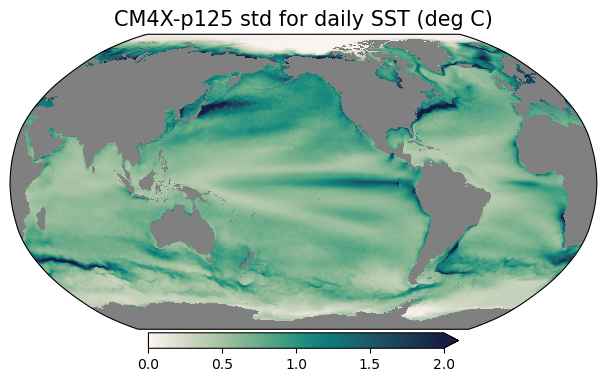

In [7]:
#map  
field = tos_daily_std 
vmin=0
vmax=2

fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 4.0),
             subplot_kw={'projection': ccrs.Robinson(central_longitude=-150)})

p=field.plot(ax=axis, x="geolon", y="geolat",vmin=vmin, vmax=vmax,
             transform=ccrs.PlateCarree(), cmap=cmocean.cm.tempo,
                           add_colorbar=False
            )
#axs.gridlines()
plt.gca().set_facecolor('gray')
plt.tick_params(labelsize=12) 
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('CM4X-p125 std for daily SST (deg C)', fontsize=15)
cbar = plt.colorbar(p,pad=0.01,spacing='uniform', 
                    extend='max',shrink=0.5,orientation='horizontal')
plt.tight_layout()
plt.show()
fig.savefig('CM4Xp125_tos_daily_std.jpg', bbox_inches='tight', dpi=400, format='jpeg')